In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import spacy
import random
import numpy as np
 
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext  
from torchtext import data
import optuna;


c:\Users\sotik\anaconda3\envs\py11_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this task, the machine learning model that predicts which Tweets are about real disasters and which one’s aren’t was built. Dataset consist from  10,000 tweets which were classified which are divided into two groups: false information and true. The goal of the assignment is to build a model that can predict the truth of a distress message.


Initially, we will download the training and test datasets, which are presented in CSV format. Initially, the twitter_base variable was created, which included the dataframe with the training set, and the test_base variable, which included the test data.


In [2]:
twitter_base = pd.read_csv('train.csv')
test_base = pd.read_csv('test.csv')
print(twitter_base.shape)
twitter_base.head(5)
print(test_base.shape)

(7613, 5)
(3263, 4)


Let's briefly consider the training set, which includes 5 features: identification number, location, message text, as well as a binary feature that characterizes the relevance of the message to the event (1) or falsity (0). The training set consists of 7613 rows
 and the test set consists of 3263 ones.

In [3]:
twitter_base.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We examine the training set for empty strings. As you can see, the keyword feature has 61 empty cells, in feature location 2533. The distribution of the dataset by the target feature is shown in the chart below.

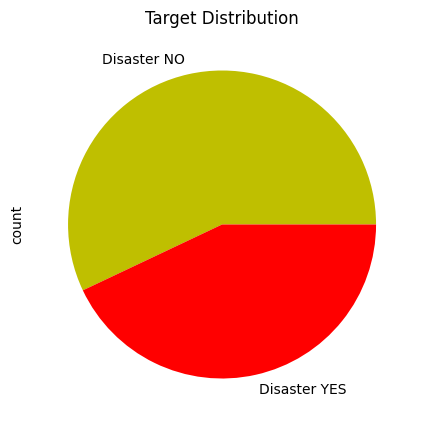

In [4]:
plot = twitter_base.target.value_counts().plot.pie(figsize = (5,5), title = "Target Distribution", labels=['Disaster NO', 'Disaster YES'], colors = ['y', "r"])

In [5]:
twitter_base.location.value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [6]:
twitter_base.keyword.value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

Let's examine the text feature for the length of each message. From the histogram below, you can see that most of the messages are between 70 and 140 characters long. For the purposes of this task, we will not abbreviate those with less than 60 characters.

<Axes: >

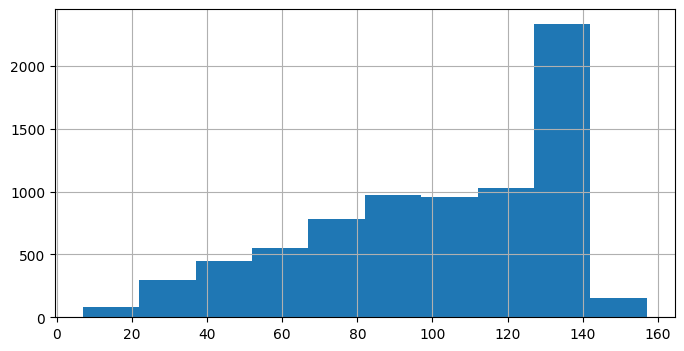

In [7]:
twitter_base['len_columns'] = twitter_base.text.apply(len)
twitter_base.len_columns.hist(figsize=(8,4))

In order to prepare the data, we will replace all empty features with: for keyword - with NON KEYS, for location with Unknown location. Next, let's combine the attributes keyword, location, text into one attribute, which we will call text. After that, we remove the id, keyword and location features from the dataset.

In [8]:
twitter_base.keyword.fillna('NON KEYS', inplace=True)
twitter_base.location.fillna('Unknown location', inplace=True)
test_base.keyword.fillna('NON KEYS', inplace=True)
test_base.location.fillna('Unknown location', inplace=True)


        

In [9]:
twitter_base['text'] = twitter_base.keyword + '. ' + twitter_base.location + '. ' + twitter_base.text
test_base['text'] = test_base.keyword + '. ' + test_base.location + '. ' + test_base.text

In [10]:

twitter_base.drop(['id', 'keyword', 'location', 'len_columns'], axis = 1, inplace=True)

In [11]:
twitter_base.head(5)

,text,target
0,NON KEYS. Unknown location. Our Deeds are the ...,1
1,NON KEYS. Unknown location. Forest fire near L...,1
2,NON KEYS. Unknown location. All residents aske...,1
3,"NON KEYS. Unknown location. 13,000 people rece...",1
4,NON KEYS. Unknown location. Just got sent this...,1


In [12]:
twitter_base.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

We will prepare the text for further training. For what, we convert all characters to lowercase, exclude spaces, as well as stopwords. To convert, let's create the prepare_text function.

In [13]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

STOPWORDS = set(stopwords.words('english'))

def prepare_text(text):
    text = text.lower()
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    text = REPLACE_BY_SPACE_RE.sub(" ", text)
    text = BAD_SYMBOLS_RE.sub('', text)
    # text = text.replace('x','')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

twitter_base['text'] = twitter_base.text.apply(prepare_text)
test_base['text'] = test_base.text.apply(prepare_text)
test_base.drop(['keyword', 'location'], axis = 1, inplace=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sotik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's divide the training set into two parts: train and valid.

In [14]:
tw_train, tw_val = train_test_split(twitter_base, train_size=0.8)

In [15]:
TEXT = data.Field(include_lengths = True)
LABEL = data.LabelField(dtype = torch.float32)
fields = [('text',TEXT), ('label',LABEL)]

In [16]:
class TwitterDataSet(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)


In [17]:
test_ds = TwitterDataSet(fields= [('text',TEXT)], df=test_base, is_test=True)

In [19]:
train_ds, val_ds = TwitterDataSet.splits(fields=fields, train_df=tw_train, val_df=tw_val)

With the help of the data.TabularData library and the build_vocab function, we will create a dictionary to later convert the tokens/words to integers. We will also load pretrained word vectors. The maximum dictionary size is 20,000 words.

In [21]:
MAX_VOCAB_SIZE = 20000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

LABEL.build_vocab(train_ds)

In [22]:
BATCH_SIZE = 64

device = torch.device('cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

test_iterator = data.BucketIterator(
    test_ds, 
    train=False,
    batch_size = BATCH_SIZE)

In [23]:
# Hyperparameters
num_epochs = 30
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In the project under consideration, I have chosen a simple model architecture, consisting of layers: embeding, LSTM and Linear (two layers). As an optimizer, I use Adam and the loss function - BCEWithLogitsLoss. The model will be trained for 20 epochs.


In [24]:
class Twitter_desaster_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
        return output


In [25]:
#creating instance of our LSTM_net class

model =  Twitter_desaster_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [26]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([20002, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0478,  0.2672, -0.1101,  ...,  0.5281, -0.4314, -0.4339],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [27]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [28]:
model.to(device) 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  
    acc = correct.sum() / len(correct)
    return acc

In [30]:
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
       
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [31]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            # text, text_lengths = text.to(device), text_lengths.to(device)
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [32]:
import time
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.568 | Train Acc: 70.46%
	 Val. Acc: 79.55%
	Train Loss: 0.455 | Train Acc: 78.31%
	 Val. Acc: 81.10%
	Train Loss: 0.384 | Train Acc: 81.69%
	 Val. Acc: 81.96%
	Train Loss: 0.288 | Train Acc: 86.06%
	 Val. Acc: 79.85%
	Train Loss: 0.213 | Train Acc: 88.93%
	 Val. Acc: 78.46%
	Train Loss: 0.182 | Train Acc: 90.02%
	 Val. Acc: 77.49%
	Train Loss: 0.162 | Train Acc: 91.27%
	 Val. Acc: 78.51%
	Train Loss: 0.162 | Train Acc: 90.73%
	 Val. Acc: 79.29%
	Train Loss: 0.159 | Train Acc: 91.02%
	 Val. Acc: 77.78%
	Train Loss: 0.151 | Train Acc: 90.91%
	 Val. Acc: 78.63%
	Train Loss: 0.141 | Train Acc: 91.46%
	 Val. Acc: 78.64%
	Train Loss: 0.149 | Train Acc: 91.11%
	 Val. Acc: 78.76%
	Train Loss: 0.151 | Train Acc: 90.72%
	 Val. Acc: 77.63%
	Train Loss: 0.137 | Train Acc: 91.67%
	 Val. Acc: 78.68%
	Train Loss: 0.147 | Train Acc: 90.90%
	 Val. Acc: 77.70%
	Train Loss: 0.146 | Train Acc: 90.37%
	 Val. Acc: 77.44%
	Train Loss: 0.147 | Train Acc: 91.03%
	 Val. Acc: 79.28%
	Train Loss: 0

In [33]:
torch.save(model.state_dict(), 'model_1th_gen.pth')

<function matplotlib.pyplot.show(close=None, block=None)>

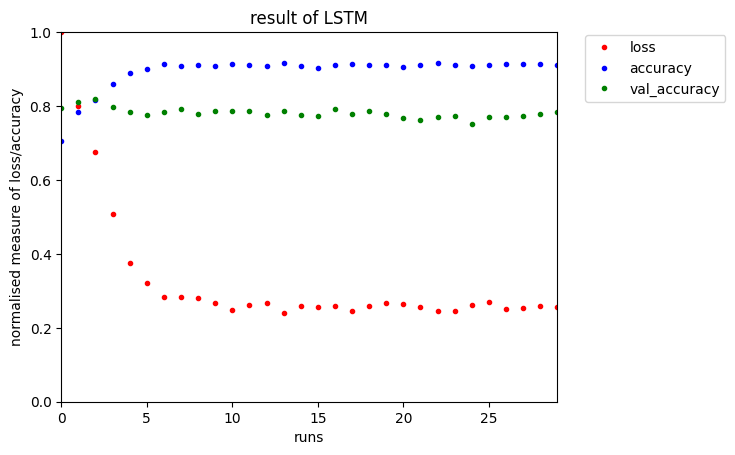

In [34]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [45]:
model.eval()

predictions = []

with torch.no_grad():
    for batch in test_iterator:
        text, text_lengths = batch.text
        pred = model(text, text_lengths).squeeze(1)
        
        for j in pred:
            predictions.append(1 if j.detach().numpy()> 0.5 else 0)

Conclusion. 
As you can see from the data above, the model does not perform well on the test set. At the same time, a fairly simple model was used in this task, which leads to an unsatisfactory result. To improve the result, it is necessary to use more advanced models, such as BERT.